In [39]:
import numpy as np
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn.linear_model
from sklearn.metrics import mean_squared_error

In [40]:
def get_points(max_x, m, b):
    expected_noise = 1.0  # assuming Y = (mX + b) + e, where e ~ N(0, 1.0)

    num_inliers = 90
    num_outliers = 10
    desired_line = lambda x : m * x + b

    xs = np.array(sorted(np.random.random(num_inliers + num_outliers)))
    xs = xs.reshape(-1, 1) * max_x
    ys = []
    for i in range(num_outliers):
        noise = np.random.normal(10, 25)
        ys.append(desired_line(xs[num_inliers + i]) + abs(noise))

    for i in range(num_inliers):
        noise = np.random.normal(0, expected_noise)
        ys.append(desired_line(xs[i]) + noise)
    ys = np.array(ys).reshape(-1, 1)
    points = np.hstack((xs, ys))
    return points

In [41]:
# N = iterations of RANSAC
# s = sample size
# d = distance to be considered well fit
# T = number of points desired to be fit properly
def ransac(points, N, s, d, T):
    min_error = float("inf")
    best_model = None

    xs = points[:,0:1]
    ys = points[:,1:2]
    for _ in range(N):
        source = np.random.randint(0, points.shape[0], size=points.shape[0])
        idx = np.arange(len(source))
        np.random.shuffle(idx)
        inds = source[idx[:s]]

        sample_xs = points[inds,0:1]
        sample_ys = points[inds,1:2]
        model = sklearn.linear_model.LinearRegression()
        model.fit(sample_xs, sample_ys)

        predicted_ys = model.predict(xs)
        dists = np.abs(predicted_ys - ys)
        well_fit_inds = np.where(dists < d)[0]
        if len(well_fit_inds) > T:
            model = sklearn.linear_model.LinearRegression()
            model.fit(
                points[well_fit_inds,0:1],
                points[well_fit_inds,1:2]
            )
            error = mean_squared_error(model.predict(points[:,0:1]), points[:,1:2])
            if error < min_error:
                min_error = error
                best_model = model
    return best_model

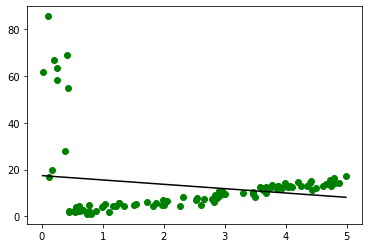

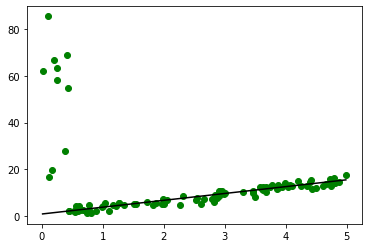

<Figure size 432x288 with 0 Axes>

In [42]:
def plot_model(points, model, fn):
    xs = points[:,0:1]
    ys = points[:,1:2]
    plt.scatter(xs, ys, color='g')
    plt.plot(xs, model.predict(xs), color='k')
    plt.show()
    plt.clf()


points = get_points(5.0, 3, 2)
original_model = sklearn.linear_model.LinearRegression()
original_model.fit(points[:,0:1], points[:,1:2])
ransac_model = ransac(points, N=100, s=20, d=1.0, T=50)

plot_model(points, original_model, "original.png")
plot_model(points, ransac_model, "ransac.png")